In [1]:
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import SGD , RMSprop
from tensorflow.keras.layers import Conv2D , BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
# from tensorflow.keras.utils import np_utils
from tensorflow.keras import backend as K
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
K.set_image_data_format('channels_first')
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
with open('X_train.pkl', 'rb') as file:
    X_train =pickle.load(file)
with open('X_test.pkl', 'rb') as file:
    X_test =pickle.load(file)
    
with open('y_train.pkl', 'rb') as file:
    y_train =pickle.load(file)
    
with open('y_test.pkl', 'rb') as file:
    y_test =pickle.load(file)
with open('X_val.pkl', 'rb') as file:
    X_val =pickle.load(file)
    
with open('y_val.pkl', 'rb') as file:
    y_val =pickle.load(file)
    

In [2]:
y_train = tf.one_hot(y_train, 2)
y_test = tf.one_hot(y_test, 2)
y_val = tf.one_hot(y_val, 2)
X_train=X_train.reshape(5216,3,150,150)
X_test=X_test.reshape(624,3,150,150)
X_val = X_val.reshape(16,3,150,150)

In [3]:
filepath="weights1.hdf5"
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [4]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation=swish_activation))
model.add(Dropout(0.4))
model.add(Dense(2 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.00005),
                  metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 150, 150)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 150, 150)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 75, 75)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 75, 75)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 75, 75)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 37, 37)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 37, 37)        1

In [5]:
history = model.fit(X_train, y_train,validation_data = (X_val , y_val) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=7)

Train on 5216 samples, validate on 16 samples
Epoch 1/7
5184/5216 [============================>.] - ETA: 0s - loss: 0.5762 - accuracy: 0.7417
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to weights1.hdf5
5216/5216 [==============================] - 30s 6ms/sample - loss: 0.5751 - accuracy: 0.7425 - val_loss: 0.9445 - val_accuracy: 0.5000
Epoch 2/7
5184/5216 [============================>.] - ETA: 0s - loss: 0.3956 - accuracy: 0.8141
Epoch 00002: val_accuracy improved from 0.50000 to 0.81250, saving model to weights1.hdf5
5216/5216 [==============================] - 9s 2ms/sample - loss: 0.3951 - accuracy: 0.8145 - val_loss: 0.6335 - val_accuracy: 0.8125
Epoch 3/7
5184/5216 [============================>.] - ETA: 0s - loss: 0.2558 - accuracy: 0.8968
Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00003: val_accuracy did not improve from 0.81250
5216/5216 [==============================] - 9s 2ms/sample - loss: 0.2548 - acc

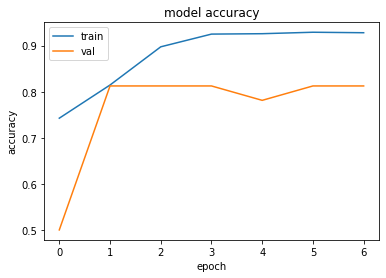

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

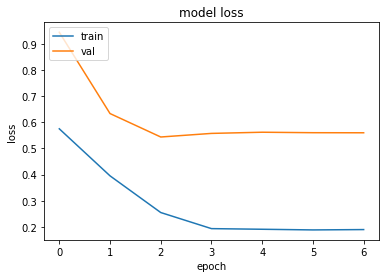

In [8]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [9]:
model.load_weights('weights1.hdf5')

In [10]:
from sklearn.metrics import classification_report
import numpy as np
pred = model.predict(X_test)
print(classification_report(np.argmax(y_test, axis = 1),np.argmax(pred, axis = 1)))

              precision    recall  f1-score   support

           0       0.91      0.46      0.61       234
           1       0.75      0.97      0.85       390

    accuracy                           0.78       624
   macro avg       0.83      0.72      0.73       624
weighted avg       0.81      0.78      0.76       624



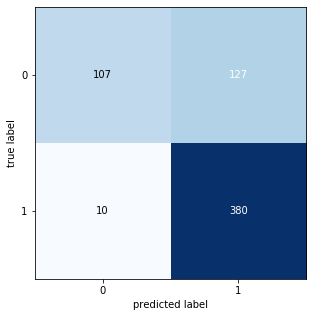

In [11]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
pred = np.argmax(pred,axis = 1) 
y_test = np.argmax(y_test,axis = 1)
CM = confusion_matrix(y_test, pred)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()